In [1]:
import MDRMF as mf
import numpy as np
from MDRMF.models import RFModeller

In [2]:
data = mf.MoleculeLoader("10K.csv", "SMILES", "r_i_docking_score").df

In [3]:
feat = mf.Featurizer(data)
features = feat.featurize("morgan", radius=2, nBits=1024)

In [4]:
X = features
y = data['scores']
ids = data['SMILES']

dataset = mf.Dataset(X=X, y=y, ids=ids)
dataset

<Dataset X.shape: (9898, 1024), y.shape: (9898,), w.shape: (9898,), ids: ['C[C@@H](NC(=O)N1C[C@H](c2ccccc2)[C@H]2COCC[C@H]21)c1ccc(NC(=O)NC2CC2)cc1'
 'O=C(Nc1cccc(C(=O)N2CCC(c3c[nH]c4ncccc34)CC2)c1)[C@@H]1Cc2ccccc2O1'
 'Cc1nn(-c2ccccc2)c2nc(C(=O)N3CCC([C@H]4C(=O)Nc5ccccc54)CC3)ccc12' ...
 'Cn1cccc(C(=O)N2CCN(C3CC3)c3ccc(Cl)cc32)c1=O'
 'O=C([O-])[C@H]1CC[C@@H](C(=O)N2CCCc3ccccc32)CC1'
 'CCNS(=O)(=O)c1cc(NCCOC)ccn1']>

In [5]:
type(dataset.y)

numpy.ndarray

In [6]:
# model = Modeller(dataset)
# sample_dataset = model._initial_sampler()
# sample_dataset

In [7]:
# model.dataset

In [8]:
dataset

<Dataset X.shape: (9898, 1024), y.shape: (9898,), w.shape: (9898,), ids: ['C[C@@H](NC(=O)N1C[C@H](c2ccccc2)[C@H]2COCC[C@H]21)c1ccc(NC(=O)NC2CC2)cc1'
 'O=C(Nc1cccc(C(=O)N2CCC(c3c[nH]c4ncccc34)CC2)c1)[C@@H]1Cc2ccccc2O1'
 'Cc1nn(-c2ccccc2)c2nc(C(=O)N3CCC([C@H]4C(=O)Nc5ccccc54)CC3)ccc12' ...
 'Cn1cccc(C(=O)N2CCN(C3CC3)c3ccc(Cl)cc32)c1=O'
 'O=C([O-])[C@H]1CC[C@@H](C(=O)N2CCCc3ccccc32)CC1'
 'CCNS(=O)(=O)c1cc(NCCOC)ccn1']>

In [9]:
RFModeller

MDRMF.models.rfmodeller.RFModeller

In [10]:
RF_mod = RFModeller(dataset, iterations=30, acquisition_size=30)
RF_mod.fit()

RandomForestRegressor()

In [11]:
new_dataset = mf.Dataset(X=X, y=y, ids=ids)
new_dataset

<Dataset X.shape: (9898, 1024), y.shape: (9898,), w.shape: (9898,), ids: ['C[C@@H](NC(=O)N1C[C@H](c2ccccc2)[C@H]2COCC[C@H]21)c1ccc(NC(=O)NC2CC2)cc1'
 'O=C(Nc1cccc(C(=O)N2CCC(c3c[nH]c4ncccc34)CC2)c1)[C@@H]1Cc2ccccc2O1'
 'Cc1nn(-c2ccccc2)c2nc(C(=O)N3CCC([C@H]4C(=O)Nc5ccccc54)CC3)ccc12' ...
 'Cn1cccc(C(=O)N2CCN(C3CC3)c3ccc(Cl)cc32)c1=O'
 'O=C([O-])[C@H]1CC[C@@H](C(=O)N2CCCc3ccccc32)CC1'
 'CCNS(=O)(=O)c1cc(NCCOC)ccn1']>

In [12]:
preds = RF_mod.predict(new_dataset)
len(preds)

9898

In [13]:
RF_mod.dataset

<Dataset X.shape: (8988, 1024), y.shape: (8988,), w.shape: (8988,), ids: ['C[C@@H](NC(=O)N1C[C@H](c2ccccc2)[C@H]2COCC[C@H]21)c1ccc(NC(=O)NC2CC2)cc1'
 'CS(=O)(=O)c1ccc(F)c(C(=O)Nc2ccc(-c3nc(-c4ccccc4)n[nH]3)cc2)c1'
 'C#Cc1cc(F)c(NC(=O)C(=O)N2CC=C(c3c[nH]c4ncccc34)CC2)c(F)c1' ...
 'Cn1cccc(C(=O)N2CCN(C3CC3)c3ccc(Cl)cc32)c1=O'
 'O=C([O-])[C@H]1CC[C@@H](C(=O)N2CCCc3ccccc32)CC1'
 'CCNS(=O)(=O)c1cc(NCCOC)ccn1']>

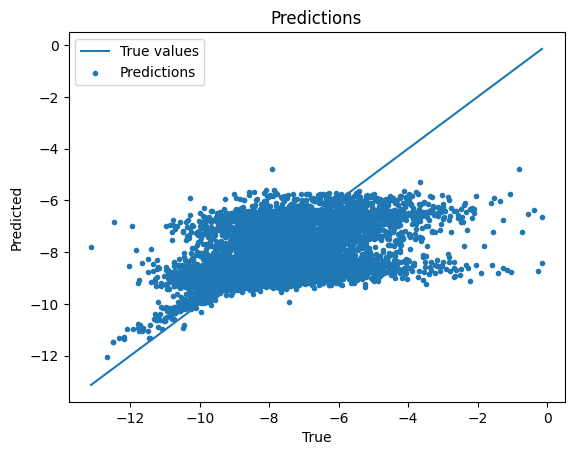

In [17]:
from matplotlib import pyplot as plt

plt.plot(new_dataset.y, new_dataset.y, label="True values")
plt.scatter(new_dataset.y, preds, marker=".", label="Predictions")
plt.gca().set(xlabel='True', ylabel='Predicted', title='Predictions')
plt.legend()

In [15]:
# m_model = RandomForestRegressor()

# m_model.fit(sample_dataset.X, sample_dataset.y)

In [16]:
# m_preds= m_model.predict(sample_dataset.X)